# Imports and Setup

In [1]:
# %load_ext cudf.pandas
%matplotlib inline

import os
import ast
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from scipy import stats
from itertools import product
from pprint import PrettyPrinter
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from visualize._utils import experiment_parameter

sns.set_style("whitegrid")
pp = PrettyPrinter(indent=4, width=100, compact=True)

CUDA device found.


# Color and Marker Legend
Returns the common legend code used for all plots.

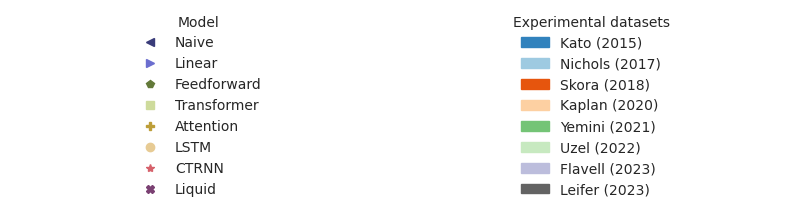

{   'color_legend': [   <matplotlib.patches.Patch object at 0x1493d809eb60>,
    'dataset_color_code': {   'Flavell2023': (   0.7372549019607844, 0.7411764705882353,
                                                 0.8627450980392157),
                              'Kaplan2020': (   0.9921568627450981, 0.8156862745098039,
                                                0.6352941176470588),
                              'Kato2015': (   0.19215686274509805, 0.5098039215686274,
                                              0.7411764705882353),
                              'Leifer2023': (   0.38823529411764707, 0.38823529411764707,
                                                0.38823529411764707),
                              'Nichols2017': (   0.6196078431372549, 0.792156862745098,
                                                 0.8823529411764706),
                              'Skora2018': (   0.9019607843137255, 0.3333333333333333,
                                               0

In [2]:
# 1. Marker and Dataset color codes
def legend_code():
    # Define the markers and labels
    markers = {
        "<": "Naive",
        ">": "Linear",
        "p": "Feedforward",
        "s": "Transformer",
        "P": "Attention",
        "o": "LSTM",
        "*": "CTRNN",
        "X": "Liquid",
    }
    markers = {value: key for key, value in markers.items()}

    model_labels = {
        "NaivePredictor": "Naive",
        "LinearRegression": "Linear",
        "FeatureFFNN": "Feedforward",
        "NeuralTransformer": "Transformer",
        "PureAttention": "Attention",
        "NetworkLSTM": "LSTM",
        "NetworkCTRNN": "CTRNN",
        "LiquidCfC": "Liquid",
    }

    dataset_labels = {
        "Kato2015": "Kato (2015)",
        "Nichols2017": "Nichols (2017)",
        "Skora2018": "Skora (2018)",
        "Kaplan2020": "Kaplan (2020)",
        "Yemini2021": "Yemini (2021)",
        "Uzel2022": "Uzel (2022)",
        "Flavell2023": "Flavell (2023)",
        "Leifer2023": "Leifer (2023)",
    }

    # Get the full 'tab20b' and 'tab20c' color maps
    full_model_palette = sns.color_palette("tab20b", n_colors=20)
    full_dataset_palette = sns.color_palette("tab20c", n_colors=20)

    # Calculate equidistant indices for the number of models and datasets
    model_indices = np.linspace(0, 19, len(model_labels), endpoint=False, dtype=int)
    dataset_indices = np.linspace(0, 19, len(dataset_labels), endpoint=False, dtype=int)

    # Sample colors equidistantly from the colormaps
    model_color_palette = [full_model_palette[i] for i in model_indices]
    dataset_color_palette = [full_dataset_palette[i] for i in dataset_indices]

    # Create custom markers for models
    marker_legend = [
        Line2D(
            [0],
            [0],
            marker=markers[model_labels[model]],
            color=model_color_palette[i],
            label=model_labels[model],
            linestyle="None",
        )
        for i, model in enumerate(model_labels)
    ]

    # Create rectangular color patches for datasets
    color_legend = [
        Patch(
            facecolor=dataset_color_palette[i],
            edgecolor=dataset_color_palette[i],
            label=dataset_labels[dataset],
        )
        for i, dataset in enumerate(dataset_labels)
    ]

    # Construct the color code dictionaries
    model_color_code = {
        model: model_color_palette[i] for i, model in enumerate(model_labels.values())
    }
    dataset_color_code = {
        dataset: dataset_color_palette[i] for i, dataset in enumerate(dataset_labels)
    }

    # Plot the legends
    fig, axs = plt.subplots(1, 2, figsize=(8, 2))

    # Model legend
    axs[0].legend(handles=marker_legend, loc="center", title="Model", frameon=False)
    axs[0].axis("off")

    # Dataset legend
    axs[1].legend(handles=color_legend, loc="center", title="Experimental datasets", frameon=False)
    axs[1].axis("off")

    plt.tight_layout()
    plt.show()

    leg_code = {
        "dataset_color_code": dataset_color_code,
        "model_color_code": model_color_code,
        "color_legend": color_legend,
        "dataset_labels": dataset_labels,
        "marker_legend": marker_legend,
        "model_labels": model_labels,
        "model_marker_code": markers,
    }

    return leg_code


# Usage example
leg_code = legend_code()
pp.pprint(leg_code)

# Dataset information

In [3]:
# %%cudf.pandas.profile


# 2. Plotting summary information about the datasets
def dataset_information(path_dict, legend_code):
    """
    path_dict: dictionary with the path to train_dataset_info,
        validation_dataset_info and combined_dataset_info.
    """

    # ### LOAD IN DATASET INFORMATION ###
    train_dataset_info = pd.read_csv(
        path_dict["train_dataset_info"],
        converters={"neurons": ast.literal_eval},
    )
    val_dataset_info = pd.read_csv(
        path_dict["val_dataset_info"],
        converters={"neurons": ast.literal_eval},
    )
    combined_dataset_info = pd.read_csv(
        path_dict["combined_dataset_info"],
        converters={"neurons": ast.literal_eval},
    )

    train_dataset_info["total_time_steps"] = (
        train_dataset_info["train_time_steps"] + val_dataset_info["val_time_steps"]
    )
    train_dataset_info["time_steps_per_neuron"] = (
        train_dataset_info["total_time_steps"] / train_dataset_info["num_neurons"]
    )
    amount_of_data_distribution = (
        train_dataset_info[["dataset", "total_time_steps"]]
        .groupby("dataset")
        .sum()
        .sort_values(by="total_time_steps", ascending=False)
    )
    amount_of_data_distribution["percentage"] = (
        amount_of_data_distribution["total_time_steps"]
        / amount_of_data_distribution["total_time_steps"].sum()
    )

    # ########### SET UP FOR FIGURES ###########
    # Get color code and legend from legend_code
    dataset_color_code = legend_code["dataset_color_code"]
    dataset_labels = legend_code["dataset_labels"]
    color_legend = legend_code["color_legend"]

    # Initialize figure
    fig = plt.figure(figsize=(20, 7))
    gs = gridspec.GridSpec(2, 4, height_ratios=[1, 1], width_ratios=[1, 1, 1, 0.25])

    # Assigning the subplots to positions in the grid
    ax1 = plt.subplot(gs[0, 0])  # Top left, 'Number of worms analyzed' pie chart
    ax2 = plt.subplot(gs[0, 1])  # Top right, 'Number of neurons per worm' bar plot
    ax3 = plt.subplot(
        gs[1, 0]
    )  # Bottom left, 'Total duration of recorded neural activity' pie chart
    ax4 = plt.subplot(
        gs[1, 1]
    )  # Bottom middle, 'Duration of recorded neural activity per worm' bar plot
    ax5 = plt.subplot(gs[0, 3])  # Bottom right, legend
    ax6 = plt.subplot(gs[0, 2])
    ax7 = plt.subplot(gs[1, 2:4])

    # ########### FOR WORMS PIE CHART ###############
    num_worms_per_dataset = combined_dataset_info[["dataset", "original_index"]]
    # Count the unique 'original_index' for each 'dataset'
    num_worms_per_dataset = (
        num_worms_per_dataset.groupby("dataset")["original_index"]
        .nunique()
        .reset_index(name="num_worms")
    )
    # Calculate the percentage for each dataset
    num_worms_per_dataset["percentage"] = (
        num_worms_per_dataset["num_worms"] / num_worms_per_dataset["num_worms"].sum()
    )
    # Sort the values by percentage in descending order
    num_worms_per_dataset = num_worms_per_dataset.sort_values(by="percentage", ascending=False)
    worm_count_label = num_worms_per_dataset["num_worms"][:7].tolist() + [""]
    # Plotting the worms per dataset pie chart
    ax1.pie(
        num_worms_per_dataset["num_worms"],
        labels=[f"{percentage:.1%}" for percentage in num_worms_per_dataset["percentage"]],
        labeldistance=1.075,
        startangle=45,
        colors=[dataset_color_code[dataset] for dataset in num_worms_per_dataset["dataset"]],
    )
    ax1.pie(
        num_worms_per_dataset["num_worms"],
        labels=[f"{n}" for n in worm_count_label],
        labeldistance=0.70,
        startangle=45,
        colors=[dataset_color_code[dataset] for dataset in num_worms_per_dataset["dataset"]],
    )
    ax1.set_title("(A) Number of worms in each experimental dataset", fontsize=14)

    # ########### NEURON POPULATION DISTRIBUTION BAR PLOT ###############
    ax2 = plt.subplot(gs[0, 1])  # Subplot for 'Number of neurons per worm' bar plot
    # Compute data for the neuron population distribution bar plot
    neuron_pop_stats = (
        train_dataset_info.groupby("dataset")["num_neurons"]
        .agg(["mean", "sem"])
        .reset_index()
        .sort_values(by="mean", ascending=False)
    )
    neuron_pop_colors = neuron_pop_stats["dataset"].apply(
        lambda x: dataset_color_code.get(x, "grey")
    )
    ax2.bar(
        neuron_pop_stats["dataset"],
        neuron_pop_stats["mean"],
        yerr=2 * neuron_pop_stats["sem"],
        color=neuron_pop_colors,
        capsize=5,
    )
    # Add a dashed horizontal line at y=302
    ax2.axhline(y=302, color="black", linestyle="dashed", linewidth=1, alpha=0.5)
    # Annotate the line
    # Use the right edge of the subplot for text annotation to prevent overflow
    right_edge = ax2.get_xlim()[1]
    ax2.text(
        right_edge,  # x position at the right edge
        302 + 1.0,  # y position at the line
        "Number of neurons in C. elegans hermaphrodite",
        horizontalalignment="right",  # Align text to the right
        fontsize=10,
        fontstyle="italic",
    )
    ax2.set_title("(B) Number of recorded neurons per worm", fontsize=14)
    ax2.set_ylabel("Neuron population size")
    ax2.set_xticklabels(neuron_pop_stats["dataset"], rotation=45, ha="right")
    ax2.set_xticks([])  # Delete xticks

    # ########### TOTAL DURATION OF RECORDED NEURAL ACTIVITY PIE CHART ###############
    ax3 = plt.subplot(
        gs[1, 0]
    )  # Subplot for 'Total duration of recorded neural activity' pie chart
    # Compute data for total duration pie chart
    total_duration_stats = (
        train_dataset_info.groupby("dataset")["total_time_steps"]
        .sum()
        .reset_index()
        .sort_values(by="total_time_steps", ascending=False)
    )
    total_duration_stats["percentage"] = (
        total_duration_stats["total_time_steps"] / total_duration_stats["total_time_steps"].sum()
    )

    # Determine the smallest slice
    smallest_slice_index = total_duration_stats["percentage"].idxmin()

    # Generate labels, omitting the smallest slice
    labels = [
        f"{percentage:.1%}" if i != smallest_slice_index else ""
        for i, percentage in enumerate(total_duration_stats["percentage"])
    ]

    total_duration_colors = total_duration_stats["dataset"].apply(
        lambda x: dataset_color_code.get(x, "grey")
    )
    # Plotting the total duration pie chart
    ax3.pie(
        total_duration_stats["total_time_steps"],
        labels=labels,
        labeldistance=1.075,
        startangle=90,
        colors=total_duration_colors,
    )
    ax3.set_title("(C) Total duration of recorded neural activity", fontsize=14)

    # ########### DURATION OF RECORDED NEURAL ACTIVITY PER WORM BAR PLOT ###############
    ax4 = plt.subplot(
        gs[1, 1]
    )  # Subplot for 'Duration of recorded neural activity per worm' bar plot
    # Compute data for recording duration bar plot
    recording_duration_stats = (
        train_dataset_info.groupby("dataset")["total_time_steps"]
        .agg(["mean", "sem"])
        .reset_index()
        .sort_values(by="mean", ascending=False)
    )
    recording_duration_colors = recording_duration_stats["dataset"].apply(
        lambda x: dataset_color_code.get(x, "grey")
    )
    ax4.bar(
        recording_duration_stats["dataset"],
        recording_duration_stats["mean"],
        yerr=2 * recording_duration_stats["sem"],
        color=recording_duration_colors,
        capsize=5,
    )
    # Add a dashed horizontal line at y=3600
    ax4.axhline(y=3600, color="black", linestyle="dashed", linewidth=1, alpha=0.5)
    # Annotate the line
    # Use the right edge of the subplot for text annotation to prevent overflow
    right_edge = ax4.get_xlim()[1]
    ax4.text(
        right_edge,  # x position at the right edge
        3600 + 10.0,  # y position at the line
        "3600 seconds = 1 hour of calcium imaging",
        horizontalalignment="right",  # Align text to the right
        fontsize=10,
        fontstyle="italic",
    )
    ax4.set_title("(D) Duration of recorded neural activity per worm", fontsize=14)
    ax4.set_ylabel("Time (s)")
    ax4.set_xticklabels(recording_duration_stats["dataset"], rotation=45, ha="right")
    ax4.set_xticks([])  # Delete xticks

    # ########### TIME STEPS PER NEURON BAR PLOT ###############
    ax6 = plt.subplot(gs[0, 2])  # Subplot for 'Number of time steps per recorded neuron' bar plot
    # Compute data for time steps per neuron bar plot
    tsn_stats = (
        train_dataset_info.groupby("dataset")["time_steps_per_neuron"]
        .agg(["mean", "sem"])
        .reset_index()
        .sort_values(by="mean", ascending=False)
    )
    tsn_colors = tsn_stats["dataset"].apply(lambda x: dataset_color_code.get(x, "grey"))
    ax6.bar(
        tsn_stats["dataset"],
        tsn_stats["mean"],
        yerr=2 * tsn_stats["sem"],
        color=tsn_colors,
        capsize=5,
    )
    # Add a dashed horizontal line at y=100
    ax6.axhline(y=180, color="black", linestyle="dashed", linewidth=1, alpha=0.5)
    # Annotate the line
    # Use the right edge of the subplot for text annotation to prevent overflow
    right_edge = ax6.get_xlim()[1]
    ax6.text(
        right_edge,  # x position at the right edge
        180 + 0.9,  # y position at the line
        "Sequence length $L=180$ was used in our experiments",
        horizontalalignment="right",  # Align text to the right
        fontsize=10,
        fontstyle="italic",
    )
    ax6.set_title("(E) Number of time steps per recorded neuron", fontsize=14)
    ax6.set_ylabel("Time steps per neuron")
    ax6.set_xticklabels(tsn_stats["dataset"], rotation=45, ha="right")
    ax6.set_xticks([])  # Delete xticks

    # ########### SAMPLING INTERVAL BAR PLOT ###############
    ax7 = plt.subplot(
        gs[1, 2:4]
    )  # Subplot for 'Sampling interval of recorded neural activity' bar plot
    # Compute data for the sampling interval bar plot
    dt_stats = (
        train_dataset_info.groupby("dataset")["original_median_dt"]
        .agg(["mean", "sem"])
        .reset_index()
        .sort_values(by="mean", ascending=False)
    )
    dt_colors = dt_stats["dataset"].apply(lambda x: dataset_color_code.get(x, "grey"))
    ax7.bar(
        dt_stats["dataset"],
        dt_stats["mean"],
        yerr=2 * dt_stats["sem"],
        color=dt_colors,
        capsize=5,
    )
    # Add a dashed horizontal line at y=1.0
    ax7.axhline(y=2 / 3, color="black", linestyle="dashed", linewidth=1, alpha=0.5)
    # Annotate the line
    # Use the right edge of the subplot for text annotation to prevent overflow
    right_edge = ax7.get_xlim()[1]
    ax7.text(
        right_edge,  # x position at the right edge
        2 / 3 + 0.001,  # y position at the line
        "We downsampled all data to $\Delta s ≈ 0.667s$ (1.5 Hz)",
        horizontalalignment="right",  # Align text to the right
        fontsize=10,
        fontstyle="italic",
    )
    ax7.set_title("(F) Sampling interval of recorded neural activity", fontsize=14)
    ax7.set_ylabel(r"Mean sampling interval ($\Delta$s)")
    ax7.set_xticklabels(dt_stats["dataset"], rotation=45, ha="right")
    ax7.set_xticks([])  # Delete xticks

    # ########### LEGEND SUBPLOT ###############
    ax5 = plt.subplot(gs[0, 3])  # Subplot for legend
    ax5.legend(
        handles=color_legend,
        labels=dataset_labels.values(),  # DEBUG
        loc="center",
        title="Experimental datasets",
        fontsize=11,
        title_fontsize=12,
    )
    ax5.get_legend().get_title().set_fontstyle("italic")
    ax5.axis("off")

    plt.tight_layout()
    plt.show()

    # Construct and return the dataset_info dictionary with all the computed stats
    dataset_info = {
        "train_dataset_info": train_dataset_info,
        "amount_of_data_distribution": amount_of_data_distribution,
        "num_worms_per_dataset": num_worms_per_dataset,
        "total_duration_stats": total_duration_stats,
        "neuron_pop_stats": neuron_pop_stats,
        "recording_duration_stats": recording_duration_stats,
        "tsn_stats": tsn_stats,
        "dt_stats": dt_stats,
    }

    return dataset_info

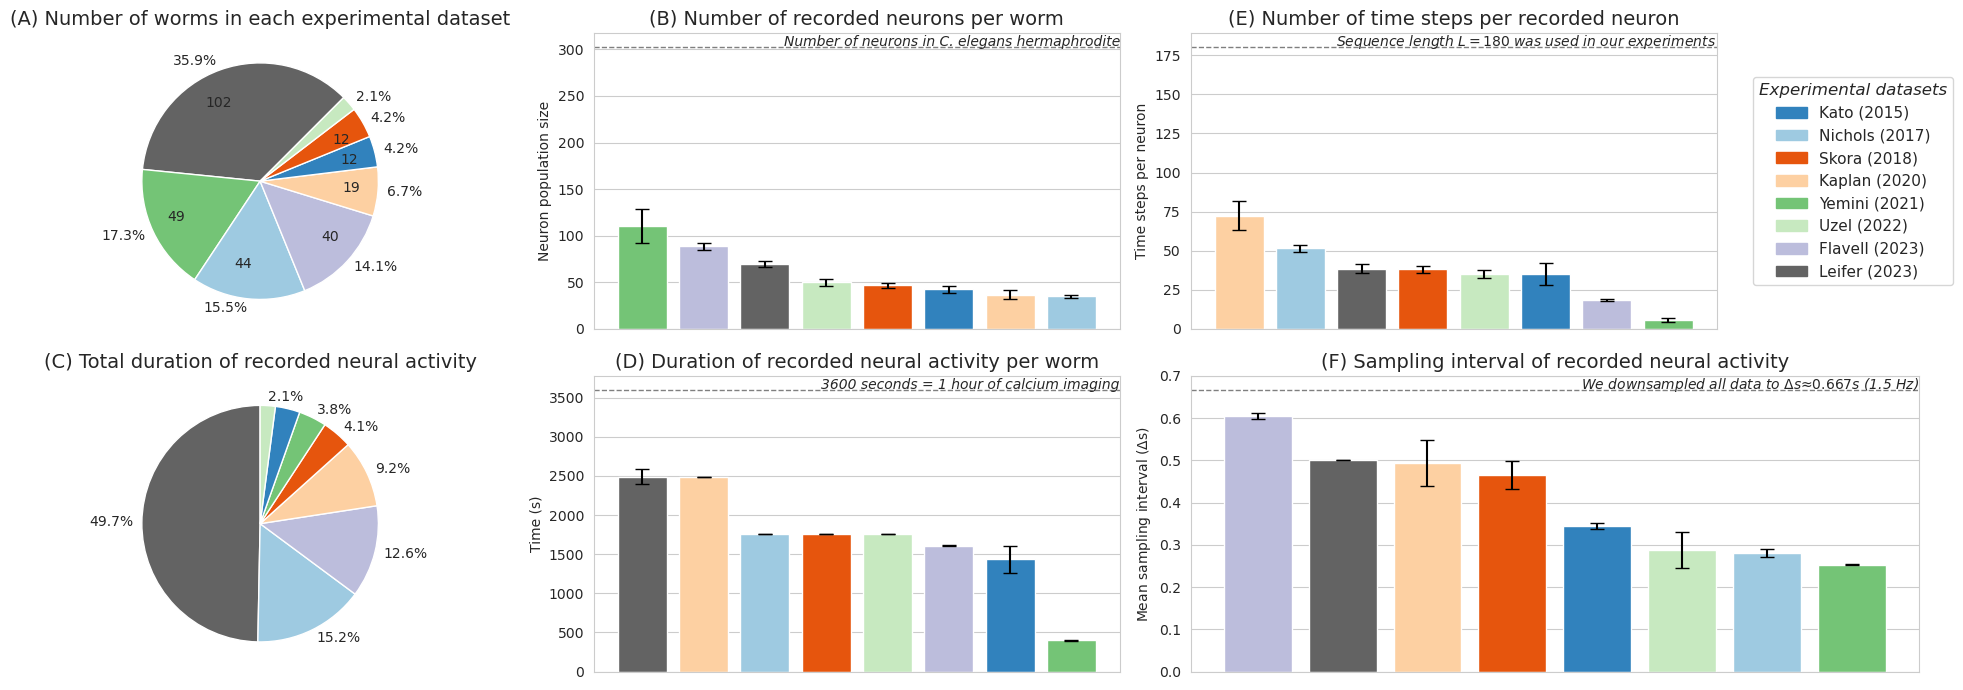

In [4]:
# Usage example
fig1_path_dict = {
    "train_dataset_info": "/om2/user/qsimeon/worm-graph/data/train_AllExperimental/train_dataset_info.csv",  # Path to train dataset info => extract number of train time steps
    "val_dataset_info": "/om2/user/qsimeon/worm-graph/data/validation_AllExperimental/val_dataset_info.csv",  # Path to val. dataset info => extract number of val. time steps
    "combined_dataset_info": "/om2/user/qsimeon/worm-graph/data/combined_AllExperimental/combined_dataset_info.csv",  # Path to combined dataset info => extract total number of worms and time step interval
}

# NOTE: Error bars on bar plots show +/- 2 SEM
dataset_info = dataset_information(path_dict=fig1_path_dict, legend_code=leg_code)

# Scaling Law Figures

In [5]:
# %%cudf.pandas.profile


def get_results_df(results_root_dir):
    """
    Recursively traverses the experiment directories, reads train_metrics.csv and
    validation_loss_per_dataset.csv files, and combines the data into a comprehensive DataFrame.

    Parameters:
    - results_root_dir: The root directory where the experiment directories are located.

    Returns:
    - A DataFrame containing all the combined results from the experiments.
    """

    def recursive_search(path, results):
        """
        Helper function to perform a recursive search for csv files in the directory tree.
        """
        for entry in os.scandir(path):
            if entry.is_dir() and any(os.scandir(entry.path)):
                recursive_search(entry.path, results)
            elif entry.is_file():
                if entry.name == "train_metrics.csv":
                    train_metrics_path = entry.path
                    validation_loss_path = os.path.join(
                        os.path.dirname(os.path.dirname(train_metrics_path)),
                        "analysis",
                        "validation_loss_per_dataset.csv",
                    )

                    if os.path.exists(validation_loss_path):
                        # Read the csv files
                        train_metrics_df = pd.read_csv(train_metrics_path)
                        validation_loss_df = pd.read_csv(validation_loss_path)

                        # Extract parameters using the provided experiment_parameter function
                        exp_path = os.path.dirname(os.path.dirname(train_metrics_path))
                        experiment_seed = experiment_parameter(exp_path, "experiment_seed")[0]
                        train_dataset = experiment_parameter(exp_path, "train_dataset")[0]
                        num_worms = experiment_parameter(exp_path, "num_worms")[0]
                        num_time_steps = experiment_parameter(exp_path, "num_time_steps")[0]
                        num_named_neurons = experiment_parameter(exp_path, "num_named_neurons")[0]
                        time_steps_per_neuron = experiment_parameter(
                            exp_path, "time_steps_per_neuron"
                        )[0]
                        train_split_first = experiment_parameter(exp_path, "train_split_first")[0]
                        hidden_size = experiment_parameter(exp_path, "hidden_size")[0]
                        batch_size = experiment_parameter(exp_path, "batch_size")[0]
                        seq_len = experiment_parameter(exp_path, "seq_len")[0]
                        resample_dt = experiment_parameter(exp_path, "resample_dt")[0]
                        time_last_epoch = experiment_parameter(exp_path, "time_last_epoch")[0]
                        computation_flops = experiment_parameter(exp_path, "computation_flops")[0]
                        num_parameters = experiment_parameter(exp_path, "num_parameters")[0]
                        model_type = experiment_parameter(exp_path, "model")[0]

                        # Calculate the min_val_loss and val_baseline
                        min_val_loss = train_metrics_df["val_loss"].min()
                        val_baseline = train_metrics_df["val_baseline"].mean()

                        # Append data to the results list
                        for _, row in validation_loss_df.iterrows():
                            results.append(
                                {
                                    "experiment_ID": os.path.basename(exp_path),
                                    "experiment_seed": experiment_seed,
                                    "train_dataset": train_dataset,
                                    "num_worms": num_worms,
                                    "num_time_steps": num_time_steps,
                                    "num_named_neurons": num_named_neurons,
                                    "time_steps_per_neuron": time_steps_per_neuron,
                                    "train_split_first": train_split_first,
                                    "hidden_size": hidden_size,
                                    "batch_size": batch_size,
                                    "seq_len": seq_len,
                                    "resample_dt": resample_dt,
                                    "time_last_epoch": time_last_epoch,
                                    "computation_flops": computation_flops,
                                    "num_parameters": num_parameters,
                                    "model_type": model_type,
                                    "min_val_loss": min_val_loss,
                                    "val_baseline": val_baseline,
                                    "validation_dataset": row["dataset"],
                                    "validation_loss": row["validation_loss"],
                                    "validation_baseline": row["validation_baseline"],
                                }
                            )

    # List to store result dictionaries
    results = []
    recursive_search(results_root_dir, results)
    return pd.DataFrame(results)

In [6]:
# # Usage example:
# results_root_directory = "/om2/vast/yanglab/shared/qsimeon/worm-graph-experiments/version_1"
# combined_results_df = get_results_df(results_root_directory)
# combined_results_df  # .head()  # To display the first few rows of the resulting DataFrame

# Scaling Number of Parameters

In [10]:
# %%cudf.pandas.profile


# We varied the hidden size as a "knob" to vary the number of parameters.
def parameters_scaling_plot(combined_results_df, legend_code, title=None):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_title(title, fontsize=14)

    # Group the DataFrame by 'model_type' and plot
    for model_type, group in combined_results_df.groupby("model_type"):
        # Skip if unrecognized type of model
        if model_type not in legend_code["model_labels"]:
            continue
        # Plot settings from legend_code
        model_label = legend_code["model_labels"][model_type]
        marker = legend_code["model_marker_code"][model_label]
        color = legend_code["model_color_code"][model_label]

        # Scatter plot of validation loss vs. number of parameters
        ax.scatter(
            group["num_parameters"],
            group["min_val_loss"],
            marker=marker,
            s=10,
            color=color,
            label=model_label,
            alpha=0.5,  # Adjust alpha to your preference
        )

    baseline = np.round(combined_results_df["val_baseline"], 3).unique()
    # DEBUG: There should be one baseline but we may have two if we ran two sets of experiments (train_split_first = True or False)
    for bsl in baseline:
        ax.plot(
            [
                combined_results_df["num_parameters"].min(),
                combined_results_df["num_parameters"].max(),
            ],
            [bsl, bsl],
            label="Baseline",
            color="black",
            alpha=0.7,
            linestyle="--",
        )

    # Create legends
    ax.legend(loc="best")
    ax.set_xlabel("Num. trainable parameters", fontsize=12, fontweight="bold")
    ax.set_ylabel("Min. Validation Loss (MSE)", fontsize=12, fontweight="bold")
    plt.show()

`results_directory = "/om2/vast/yanglab/shared/qsimeon/worm-graph-experiments/version_1/num_parameters/experimental"`

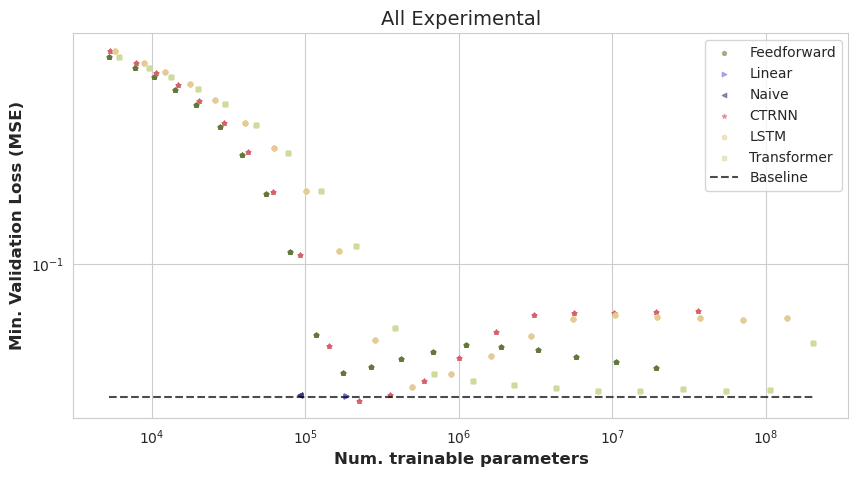

In [11]:
# Retrieve the relevant results
results_directory = "/om2/vast/yanglab/shared/qsimeon/worm-graph-experiments/version_1/num_parameters/experimental"  # real worms AllExperimental
results_df = get_results_df(results_directory)
results_df  # .head()

# Example usage:
parameters_scaling_plot(results_df, leg_code, title="All Experimental")

`results_directory = "/om2/vast/yanglab/shared/qsimeon/worm-graph-experiments/version_1/num_parameters/synthetic"`

In [12]:
# # Retrieve the relevant results
# results_directory = "/om2/vast/yanglab/shared/qsimeon/worm-graph-experiments/version_1/num_parameters/synthetic/seed_0"  # synthetic data Sines
# results_df = get_results_df(results_directory)
# results_df  # .head()

# # Example usage:
# parameters_scaling_plot(results_df, leg_code, title="Sines")

In [13]:
# # Retrieve the relevant results
# results_directory = "/om2/vast/yanglab/shared/qsimeon/worm-graph-experiments/num_parameters/synthetic/seed_1"  # synthetic data Lorenz
# results_df = get_results_df(results_directory)
# results_df  # .head()

# # Example usage:
# parameters_scaling_plot(results_df, leg_code, title="Lorenz")

In [14]:
# # Retrieve the relevant results
# results_directory = "/om2/vast/yanglab/shared/qsimeon/worm-graph-experiments/num_parameters/synthetic/seed_2"  # synthetic data White Noise
# results_df = get_results_df(results_directory)
# results_df  # .head()

# # Example usage:
# parameters_scaling_plot(results_df, leg_code, title="White Noise")

In [15]:
# # Retrieve the relevant results
# results_directory = "/om2/vast/yanglab/shared/qsimeon/worm-graph-experiments/num_parameters/synthetic/seed_3"  # synthetic data Random Walk
# results_df = get_results_df(results_directory)
# results_df  # .head()

# # Example usage:
# parameters_scaling_plot(results_df, leg_code, title="Random Walk")

In [16]:
# # Retrieve the relevant results
# results_directory = "/om2/vast/yanglab/shared/qsimeon/worm-graph-experiments/num_parameters/synthetic/seed_5"  # synthetic data Shakespeare
# results_df = get_results_df(results_directory)
# results_df  # .head()

# # Example usage:
# parameters_scaling_plot(results_df, leg_code, title="Shakespeare")

In [17]:
# %%cudf.pandas.profile


def print_best_model_info(df):
    """
    Prints the hidden size and number of parameters for the entry with the lowest min_val_loss
    for each unique model type in the DataFrame.

    Parameters:
    - df: A pandas DataFrame containing the model results.
    """
    model_types = df["model_type"].unique()
    for model_type in model_types:
        # Filter for the current model type
        model_df = df[df["model_type"] == model_type]

        # Find the index of the minimum validation loss
        idx_min_val_loss = model_df["min_val_loss"].idxmin()

        # Get the row for the minimum validation loss
        min_val_loss_row = model_df.loc[idx_min_val_loss]

        # Extract the hidden_size and num_parameters
        hidden_size = min_val_loss_row["hidden_size"]
        num_parameters = min_val_loss_row["num_parameters"]
        min_val_loss = min_val_loss_row["min_val_loss"]

        print(
            f"The {model_type} model achieved its lowest min_val_loss of {min_val_loss:.6f} "
            f"with a hidden_size of {hidden_size} and num_parameters of {num_parameters}."
        )


# Example usage:
print_best_model_info(results_df)

The NetworkLSTM model achieved its lowest min_val_loss of 0.037896 with a hidden_size of 214.0 and num_parameters of 498280.0.
The NeuralTransformer model achieved its lowest min_val_loss of 0.036612 with a hidden_size of 2124.0 and num_parameters of 55468562.0.
The LinearRegression model achieved its lowest min_val_loss of 0.035306 with a hidden_size of nan and num_parameters of 183616.0.
The NetworkCTRNN model achieved its lowest min_val_loss of 0.033926 with a hidden_size of 214.0 and num_parameters of 222434.0.
The NaivePredictor model achieved its lowest min_val_loss of 0.035402 with a hidden_size of nan and num_parameters of 92111.0.
The FeatureFFNN model achieved its lowest min_val_loss of 0.042308 with a hidden_size of 214.0 and num_parameters of 176210.0.


# Data Scaling

# Mixed Dataset Scaling

In [19]:
# %%cudf.pandas.profile


def mixed_scaling_plot(combined_results_df, legend_code):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.set_xscale("log")
    ax.set_yscale("log")

    for model_type, model_group in combined_results_df.groupby("model_type"):
        # Skip if unrecognized type of model
        if model_type not in legend_code["model_labels"]:
            continue

        # Obtain values for plotting
        nts = model_group["num_time_steps"]
        val_loss = model_group["min_val_loss"]
        baseline_loss = model_group["val_baseline"].iloc[0]  # Baseline is constant

        # Plot settings from legend_code
        model_label = legend_code["model_labels"][model_type]
        marker = legend_code["model_marker_code"][model_label]
        color = legend_code["model_color_code"][model_label]

        # Scatter plot
        ax.scatter(
            nts,
            val_loss,
            marker=marker,
            color=color,  # TODO: is this preventing the alpha from kicking in?
            s=7,
            label=None,
            alpha=0.3,
        )

        # Baseline plot
        ax.axhline(
            baseline_loss,
            label="Baseline"
            if model_type == list(legend_code["model_labels"].values())[0]
            else "_nolegend_",
            color="black",
            alpha=0.7,
            linestyle="--",
        )

        # Regression line
        slope, intercept, r_value, p_value, std_err = stats.linregress(
            np.log(nts), np.log(val_loss)
        )
        fit_label = f"y = {slope:.2f}x + {intercept:.1f}\n" f"$R^2={r_value**2:.2f}$"
        x_fit = np.linspace(nts.min(), nts.max(), 10000)
        y_fit = np.exp(intercept + slope * np.log(x_fit))

        ax.plot(x_fit, y_fit, color=color, label=fit_label)

    # Handles and labels for first legend
    handles, labels = ax.get_legend_handles_labels()

    # Create the second legend
    legend2 = ax.legend(
        handles=legend_code["marker_legend"],
        loc="center right",
        bbox_to_anchor=(0.995, 0.85),
        title="Model architecture",
        fontsize="x-small",
    )
    ax.get_legend().get_title().set_fontstyle("italic")
    ax.get_legend().get_title().set_fontsize("x-small")
    ax.add_artist(legend2)

    # Display both legends
    ax.legend(handles, labels, loc="center left", bbox_to_anchor=(0.01, 0.25), fontsize="xx-small")

    ax.set_xlabel("Num. train time steps", fontsize=12)
    ax.set_ylabel("Validation MSE Loss", fontsize=12)

    plt.show()

`results_directory = "/om2/vast/yanglab/shared/qsimeon/worm-graph-experiments/version_1/num_time_steps/experimental"`

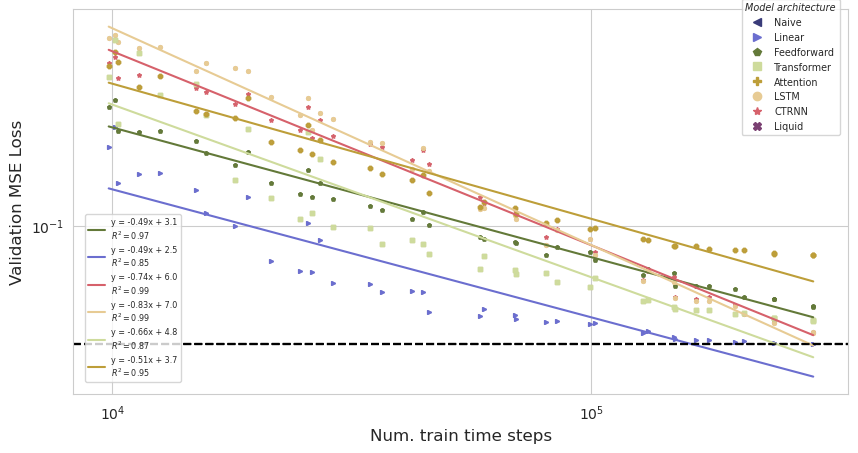

In [25]:
# Retrieve the relevant results
results_directory = (
    "/om2/vast/yanglab/shared/qsimeon/worm-graph-experiments/version_1/num_time_steps/experimental"
)
results_df = get_results_df(results_directory)
results_df  # .head()

# Example usage
mixed_scaling_plot(results_df, leg_code)

In [26]:
results_df

,experiment_ID,experiment_seed,train_dataset,num_worms,num_time_steps,num_named_neurons,time_steps_per_neuron,train_split_first,hidden_size,batch_size,...,resample_dt,time_last_epoch,computation_flops,num_parameters,model_type,min_val_loss,val_baseline,validation_dataset,validation_loss,validation_baseline
0,exp0,1,Flavell2023_Kaplan2020_Kato2015_Leifer2023_Nic...,10,9822,195,22.665591,True,516.0,128,...,0.666,0.058742,577920.0,580286,FeatureFFNN,0.282143,0.035452,Kato2015,0.123024,0.023300
1,exp0,1,Flavell2023_Kaplan2020_Kato2015_Leifer2023_Nic...,10,9822,195,22.665591,True,516.0,128,...,0.666,0.058742,577920.0,580286,FeatureFFNN,0.282143,0.035452,Nichols2017,0.088424,0.022736
2,exp0,1,Flavell2023_Kaplan2020_Kato2015_Leifer2023_Nic...,10,9822,195,22.665591,True,516.0,128,...,0.666,0.058742,577920.0,580286,FeatureFFNN,0.282143,0.035452,Skora2018,0.139061,0.018909
3,exp0,1,Flavell2023_Kaplan2020_Kato2015_Leifer2023_Nic...,10,9822,195,22.665591,True,516.0,128,...,0.666,0.058742,577920.0,580286,FeatureFFNN,0.282143,0.035452,Kaplan2020,0.128743,0.008870
4,exp0,1,Flavell2023_Kaplan2020_Kato2015_Leifer2023_Nic...,10,9822,195,22.665591,True,516.0,128,...,0.666,0.058742,577920.0,580286,FeatureFFNN,0.282143,0.035452,Yemini2021,0.296786,0.037193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915,exp9,2,Flavell2023_Kaplan2020_Kato2015_Leifer2023_Nic...,48,44579,243,18.475207,True,408.0,128,...,0.666,2.857198,581400.0,582110,NetworkCTRNN,0.194704,0.035455,Kaplan2020,0.076884,0.008870
1916,exp9,2,Flavell2023_Kaplan2020_Kato2015_Leifer2023_Nic...,48,44579,243,18.475207,True,408.0,128,...,0.666,2.857198,581400.0,582110,NetworkCTRNN,0.194704,0.035455,Yemini2021,0.201700,0.037193
1917,exp9,2,Flavell2023_Kaplan2020_Kato2015_Leifer2023_Nic...,48,44579,243,18.475207,True,408.0,128,...,0.666,2.857198,581400.0,582110,NetworkCTRNN,0.194704,0.035455,Uzel2022,0.263504,0.015039
1918,exp9,2,Flavell2023_Kaplan2020_Kato2015_Leifer2023_Nic...,48,44579,243,18.475207,True,408.0,128,...,0.666,2.857198,581400.0,582110,NetworkCTRNN,0.194704,0.035455,Flavell2023,0.201945,0.033746


# Individual Dataset Scaling

In [21]:
# %%cudf.pandas.profile


def individual_scaling_plot(combined_results_df, legend_code):
    fig, axs = plt.subplots(1, len(combined_results_df["model_type"].unique()), figsize=(15, 5))

    if len(combined_results_df["model_type"].unique()) > 1:
        axs = axs.flatten()
    else:
        axs = [axs]

    for idx, (model_type, model_group) in enumerate(combined_results_df.groupby("model_type")):
        # Skip if unrecognized type of model
        if model_type not in legend_code["model_labels"]:
            continue

        model_label = legend_code["model_labels"][model_type]

        ax = axs[idx]
        ax.set_xscale("log")
        ax.set_yscale("log")

        for dataset_name, dataset_group in model_group.groupby("validation_dataset"):
            color = legend_code["dataset_color_code"][dataset_name]

            # Scatter plot for individual dataset
            ax.scatter(
                dataset_group["num_time_steps"],
                dataset_group["validation_loss"],
                s=7,
                color=color,
                label=dataset_name,
                alpha=0.3,
            )

            # Baseline horizontal line
            baseline_loss = dataset_group["validation_baseline"].iloc[0]
            ax.axhline(
                y=baseline_loss,
                color=color,
                linestyle="--",
                linewidth=1,
                alpha=0.7,
                label=f"{dataset_name} baseline",
            )

            # Linear regression
            slope, intercept, r_value, p_value, std_err = stats.linregress(
                np.log(dataset_group["num_time_steps"]),
                np.log(dataset_group["validation_loss"]),
            )

            # Plot regression line
            x_reg = np.linspace(
                dataset_group["num_time_steps"].min(),
                dataset_group["num_time_steps"].max(),
                100,
            )
            y_reg = np.exp(intercept + slope * np.log(x_reg))
            ax.plot(x_reg, y_reg, color=color)

        ax.set_title(model_label, fontweight="bold")
        ax.set_xlabel("Num. train time steps")
        if idx == 0:
            ax.set_ylabel("Validation Loss")
        else:
            ax.set_yticklabels([])

    # Adjust the layout and display the plot
    plt.tight_layout()
    plt.show()

`results_directory = "/om2/vast/yanglab/shared/qsimeon/worm-graph-experiments/version_1/num_time_steps/experimental"`

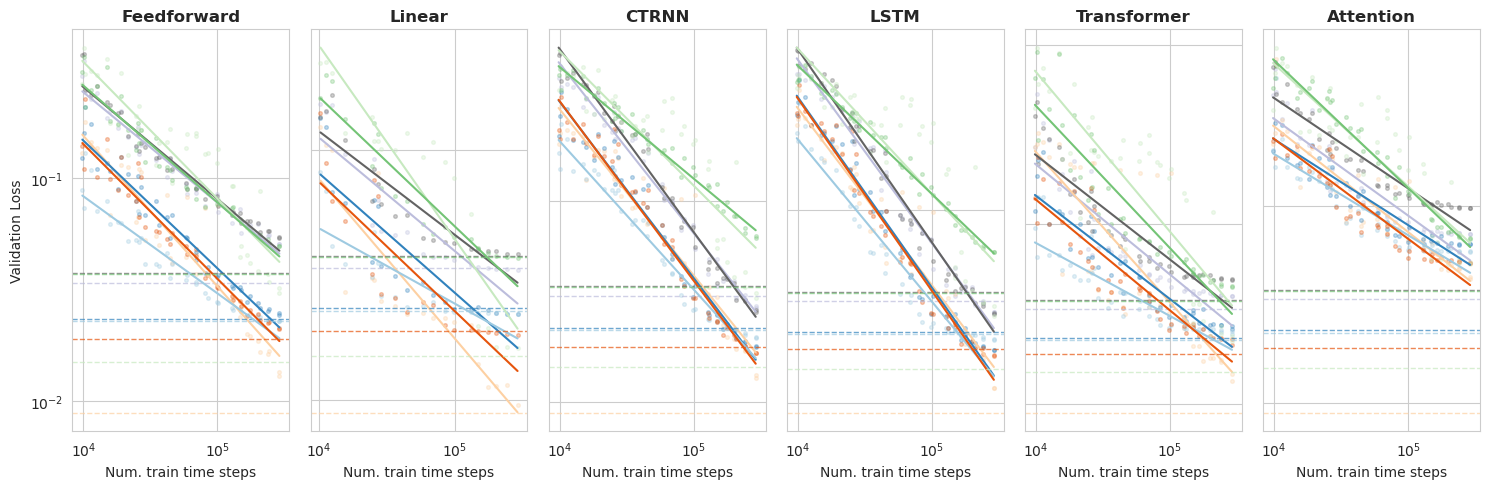

In [39]:
# Retrieve the relevant results
results_directory = (
    "/om2/vast/yanglab/shared/qsimeon/worm-graph-experiments/version_1/num_time_steps/experimental"
)
results_df = get_results_df(results_directory)
results_df.head()

# Example usage:
individual_scaling_plot(results_df, leg_code)

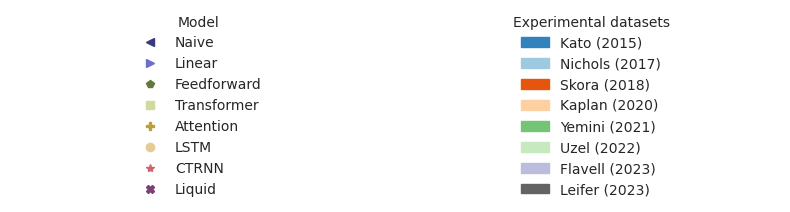

# Cross Dataset Generalization
A heatmap showing the validation loss on all of the experimental datasets after a model has been trained on just one of the them.

In [22]:
# %%cudf.pandas.profile


def cross_dataset(combined_results_df, legend_code):
    dataset_labels = legend_code["dataset_labels"]
    model_labels = legend_code["model_labels"]

    # Prepare a DataFrame for the heatmap
    heatmap_data = pd.DataFrame(
        columns=dataset_labels.values(),
        index=pd.MultiIndex.from_product([model_labels.values(), dataset_labels.values()]),
    )

    # Fill the DataFrame with validation losses
    for (model_type, train_dataset), group in combined_results_df.groupby(
        ["model_type", "train_dataset"]
    ):
        for val_dataset in dataset_labels.keys():
            val_loss = group[group["validation_dataset"] == val_dataset]["validation_loss"].mean()
            heatmap_data.at[
                (model_labels[model_type], dataset_labels[train_dataset]),
                dataset_labels[val_dataset],
            ] = val_loss

    # Set up the figure for the heatmap
    num_models = len(model_labels)
    fig, ax = plt.subplots(figsize=(num_models * 4, 8))  # Adjust the size as needed

    # Create the heatmap
    sns.heatmap(
        heatmap_data.astype(float).unstack(level=0),
        annot=True,
        fmt=".2f",
        cmap="viridis",
        ax=ax,
        cbar_kws={"label": "Validation Loss (MSE)"},
    )

    # Set the title and axis labels
    ax.set_title("Cross Dataset Generalization", fontsize=16)
    ax.set_xlabel("Train Dataset", fontsize=14)
    ax.set_ylabel("Model Type and Validation Dataset", fontsize=14)

    plt.tight_layout()
    plt.show()

In [23]:
# Retrieve the relevant results
results_directory = (
    "/om2/vast/yanglab/shared/qsimeon/worm-graph-experiments/version_1/cross_dataset/experimental"
)
results_df = get_results_df(results_directory)
results_df #.head()

# Usage example
cross_dataset(results_df, leg_code)

KeyError: 'model_type'